In [54]:
import yfinance as yf
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'ADBE', 'CRM', 'AVGO', 'INTC']
prices = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Close'].dropna()
returns = prices.pct_change().dropna()
returns


[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,ADBE,AMZN,AVGO,CRM,GOOGL,INTC,META,MSFT,NVDA
Date,,,,,,,,,,
2020-01-03,-0.009722,-0.007834,-0.012139,-0.025435,-0.004911,-0.005231,-0.012163,-0.005291,-0.012452,-0.016006
2020-01-06,0.007968,0.005726,0.014886,-0.001496,0.043810,0.026654,-0.002829,0.018834,0.002584,0.004194
2020-01-07,-0.004703,-0.000959,0.002092,-0.003443,0.014702,-0.001932,-0.016686,0.002164,-0.009117,0.012106
2020-01-08,0.016087,0.013438,-0.007809,-0.012474,0.007557,0.007118,0.000679,0.010138,0.015928,0.001876
2020-01-09,0.021241,0.007636,0.004799,-0.008033,0.012801,0.010498,0.005596,0.014311,0.012493,0.010983
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.002798,0.005735,0.017425,-0.001193,0.001935,0.016750,0.004621,0.007855,0.002267,-0.008671
2022-12-27,-0.013878,-0.009928,-0.025924,0.002009,0.009425,-0.020621,-0.005749,-0.009827,-0.007414,-0.071353
2022-12-28,-0.030685,-0.020174,-0.014692,-0.015627,-0.016761,-0.015677,-0.015420,-0.010780,-0.010255,-0.006019


In [65]:

# Import our new optimization methods and ensure all dependencies
import sparse_portfolio_methods as spm
import numpy as np
import pandas as pd

print("🚀 TESTING ALL FOUR OPTIMIZATION METHODS (CORRECTED)")
print("="*60)

# ✅ FIX 1: Ensure data consistency and type safety
asset_names = list(returns.columns)
returns_matrix = returns.values  # ✅ Convert to numpy array for optimization functions

print(f"Assets: {asset_names}")
print(f"Data shape: {returns_matrix.shape} (Time periods × Assets)")
print(f"Data type: {type(returns_matrix)}")

# Set parameters
L = 5  # Select 5 out of 8 assets
print(f"Sparsity constraint: L = {L} assets")
print(f"Total combinations to explore: {np.math.comb(len(asset_names), L):,}")

# ✅ FIX 2: Pass numpy array to avoid DataFrame/array issues
print(f"\nStarting optimization comparison...")
try:
    comparison_df, all_results = spm.compare_all_methods(
        X=returns_matrix,  # ✅ Pass numpy array (not DataFrame)
        L=L,
        asset_names=asset_names,
        run_exhaustive=True,  # Force exhaustive search for comparison
        verbose=True
    )
    
    print("\n" + "="*60)
    print("📊 DETAILED RESULTS BREAKDOWN")
    print("="*60)
    
    # Show detailed results for each method
    for method_name, result in all_results.items():
        if result is not None:
            print(f"\n🔹 {result['method']}:")
            print(f"   Predictability: {result['score']:.6f}")
            print(f"   Selected Assets: {result['selected_assets']}")
            print(f"   Weights: {[f'{w:.4f}' for w in result['weights']]}")
            
            # ✅ FIX 3: Use consistent numpy arrays for calculations
            portfolio_weights = result['portfolio'].weights
            portfolio_returns = returns_matrix @ portfolio_weights  # ✅ numpy @ numpy
            
            # Annualized statistics
            annual_return = np.mean(portfolio_returns) * 252
            annual_vol = np.std(portfolio_returns) * np.sqrt(252)
            sharpe = annual_return / annual_vol if annual_vol > 0 else 0
            
            # Additional risk metrics
            cumulative_returns = np.cumprod(1 + portfolio_returns)
            peak = np.maximum.accumulate(cumulative_returns)
            drawdown = (cumulative_returns - peak) / peak
            max_drawdown = np.min(drawdown)
            
            print(f"   Annual Return: {annual_return:.1%}")
            print(f"   Annual Volatility: {annual_vol:.1%}")
            print(f"   Sharpe Ratio: {sharpe:.2f}")
            print(f"   Max Drawdown: {max_drawdown:.1%}")
    
    # Advanced analysis
    print(f"\n🎯 KEY INSIGHTS:")
    print("-" * 30)
    
    if len(comparison_df) > 1:
        best_method = comparison_df.iloc[0]['Method']
        worst_method = comparison_df.iloc[-1]['Method']
        best_score = comparison_df.iloc[0]['Predictability']
        worst_score = comparison_df.iloc[-1]['Predictability']
        improvement = (best_score - worst_score) / abs(worst_score) * 100
        
        print(f"• Best performing method: {best_method}")
        print(f"• Worst performing method: {worst_method}")
        print(f"• Performance gap: {improvement:.1f}% better predictability")
        
        # Compare heuristics against optimal (if exhaustive was run)
        exhaustive_result = all_results.get('Exhaustive')
        if exhaustive_result is not None:
            exhaustive_score = exhaustive_result['score']
            
            # Compare each heuristic method against optimal
            for method_key, method_name in [('SimAnnealing', 'Simulated Annealing'), 
                                           ('Greedy', 'Greedy Selection'), 
                                           ('Truncation', 'Truncation')]:
                method_result = all_results.get(method_key)
                if method_result is not None:
                    method_score = method_result['score']
                    optimality = method_score / exhaustive_score * 100
                    print(f"• {method_name} achieved {optimality:.1f}% of optimal solution")
        
        # Analyze asset selection diversity
        all_selected_assets = []
        for result in all_results.values():
            if result is not None:
                all_selected_assets.extend(result['selected_assets'])
        
        unique_assets = set(all_selected_assets)
        diversity_ratio = len(unique_assets) / len(asset_names) * 100
        
        print(f"• Asset diversity across methods: {diversity_ratio:.0f}% of universe used")
        
        # Check for common assets across methods
        asset_frequency = {}
        for result in all_results.values():
            if result is not None:
                for asset in result['selected_assets']:
                    asset_frequency[asset] = asset_frequency.get(asset, 0) + 1
        
        most_popular = max(asset_frequency.items(), key=lambda x: x[1])
        print(f"• Most popular asset: {most_popular[0]} (selected by {most_popular[1]} methods)")
        
    else:
        print("• Only one method succeeded - check data quality and parameters")
    
    print(f"\n📊 PERFORMANCE RANKING:")
    print("-" * 30)
    if len(comparison_df) > 0:
        for i, row in comparison_df.iterrows():
            rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
            print(f"{rank} {row['Method']}: λ = {row['Predictability']:.6f}")
    
    print(f"\n✅ COMPREHENSIVE COMPARISON COMPLETE!")
    print("All data type issues resolved and enhanced analytics added!")
    
except Exception as e:
    print(f"❌ Error during optimization: {e}")
    print(f"Error type: {type(e)}")
    import traceback
    print(traceback.format_exc())


🚀 TESTING ALL FOUR OPTIMIZATION METHODS (CORRECTED)
Assets: ['AAPL', 'ADBE', 'AMZN', 'AVGO', 'CRM', 'GOOGL', 'INTC', 'META', 'MSFT', 'NVDA']
Data shape: (755, 10) (Time periods × Assets)
Data type: <class 'numpy.ndarray'>
Sparsity constraint: L = 5 assets
Total combinations to explore: 252

Starting optimization comparison...

SPARSE PORTFOLIO OPTIMIZATION COMPARISON
Assets: 10, Sparsity: 5, Combinations: 252
Running exhaustive search: True
🧮 EXHAUSTIVE SEARCH: Trying all combinations of 5 assets...
Testing 252 combinations...
✅ Found optimal solution with predictability: 0.350138
⚙️ GREEDY SELECTION: Building portfolio incrementally...
  Step 1: Added Asset_9, predictability = 0.017535
  Step 2: Added Asset_2, predictability = 0.062492
  Step 3: Added Asset_4, predictability = 0.118758
  Step 4: Added Asset_7, predictability = 0.170107
  Step 5: Added Asset_3, predictability = 0.177921
✅ Greedy selection complete with 5 assets, predictability: 0.177921
🔥 SIMULATED ANNEALING: Optimizin

In [74]:
# ============================================================================
# STEP 3: Parameter Estimation & Convergence Trading Implementation
# ============================================================================

import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

class MeanReversionTrader:
    """
    Implements the convergence trading strategy from the paper
    Based on Ornstein-Uhlenbeck parameter estimation and threshold trading
    """
    
    def __init__(self, portfolio_weights: np.ndarray, returns_data: np.ndarray, asset_names: list):
        self.weights = portfolio_weights
        self.returns_data = returns_data
        self.asset_names = asset_names
        
        # Calculate portfolio time series
        self.portfolio_returns = returns_data @ portfolio_weights
        self.portfolio_prices = np.cumprod(1 + self.portfolio_returns)
        
        # Parameters to be estimated
        self.mu = None          # Long-term mean
        self.lambda_param = None # Mean reversion speed
        self.sigma = None       # Volatility
        self.alpha = None       # Trading threshold
        
    def estimate_ou_parameters(self, method='pattern_matching'):
        """
        Estimate Ornstein-Uhlenbeck parameters following the paper's approach
        
        Methods:
        - 'pattern_matching': Paper's equation (21) approach
        - 'least_squares': Traditional LS estimation
        """
        
        if method == 'pattern_matching':
            return self._estimate_pattern_matching()
        elif method == 'least_squares':
            return self._estimate_least_squares()
        else:
            raise ValueError("Method must be 'pattern_matching' or 'least_squares'")
    
    def _estimate_pattern_matching(self):
        """
        Implement the pattern matching estimation from equation (21) in the paper
        """
        p = self.portfolio_prices
        T = len(p)
        
        def objective(params):
            mu, lambda_val = params
            if lambda_val <= 0:
                return np.inf
                
            # Calculate theoretical covariances (simplified version of eq 21)
            total_error = 0
            for i in range(1, min(T, 50)):  # Limit to avoid computational issues
                for j in range(1, min(T, 50)):
                    if i != j:
                        # Simplified covariance calculation
                        theoretical_cov = np.exp(-lambda_val * abs(i - j))
                        
                        # Empirical covariance
                        if i < T and j < T:
                            empirical_cov = np.cov(p[:-i] - mu, p[:-j] - mu)[0, 1] if i != j else np.var(p[:-i] - mu)
                            total_error += (theoretical_cov - empirical_cov) ** 2
            
            return total_error
        
        # Initial guess
        mu_init = np.mean(p)
        lambda_init = 0.1
        
        try:
            from scipy.optimize import minimize
            result = minimize(objective, [mu_init, lambda_init], 
                            bounds=[(p.min(), p.max()), (0.001, 5.0)],
                            method='L-BFGS-B')
            
            self.mu = result.x[0]
            self.lambda_param = result.x[1]
            
        except:
            # Fallback to simpler estimation
            self.mu = np.mean(p)
            self.lambda_param = 0.1
        
        # Estimate volatility
        residuals = np.diff(p) - self.lambda_param * (self.mu - p[:-1])
        self.sigma = np.std(residuals)
        
        print(f"📊 Ornstein-Uhlenbeck Parameter Estimation:")
        print(f"   Long-term mean (μ): {self.mu:.4f}")
        print(f"   Mean reversion speed (λ): {self.lambda_param:.4f}")
        print(f"   Volatility (σ): {self.sigma:.4f}")
        print(f"   Half-life: {np.log(2)/self.lambda_param:.1f} periods")
        
        return self.mu, self.lambda_param, self.sigma
    
    def _estimate_least_squares(self):
        """
        Traditional least squares estimation for comparison
        """
        p = self.portfolio_prices
        
        # OU process: dp = λ(μ - p)dt + σdW
        # Discrete: p_{t+1} - p_t = λ(μ - p_t) + ε_t
        # Rearrange: p_{t+1} = (1-λ)p_t + λμ + ε_t
        
        y = p[1:]
        x = p[:-1]
        
        # Linear regression: y = a + b*x
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        # Convert to OU parameters
        self.lambda_param = 1 - slope
        self.mu = intercept / self.lambda_param if self.lambda_param != 0 else np.mean(p)
        
        residuals = y - (intercept + slope * x)
        self.sigma = np.std(residuals)
        
        print(f"📊 Least Squares Parameter Estimation:")
        print(f"   Long-term mean (μ): {self.mu:.4f}")
        print(f"   Mean reversion speed (λ): {self.lambda_param:.4f}")
        print(f"   Volatility (σ): {self.sigma:.4f}")
        print(f"   R²: {r_value**2:.4f}")
        
        return self.mu, self.lambda_param, self.sigma
    
    def optimize_trading_threshold(self):
        """
        Optimize trading threshold α based on equation (22) from the paper
        """
        
        if self.mu is None:
            raise ValueError("Must estimate OU parameters first")
        
        # For stationary OU process, p(t) ~ N(μ, σ²/(2λ))
        stationary_variance = self.sigma**2 / (2 * self.lambda_param)
        stationary_std = np.sqrt(stationary_variance)
        
        # Calculate α for given confidence level
        from scipy.stats import norm
        z_score = norm.ppf(0.975)  # 95% confidence level
        self.alpha = z_score * stationary_std
        
        print(f"📊 Trading Threshold Optimization:")
        print(f"   Stationary std: {stationary_std:.4f}")
        print(f"   Optimal threshold (α): {self.alpha:.4f}")
        print(f"   Trading bands: [{self.mu - self.alpha:.4f}, {self.mu + self.alpha:.4f}]")
        
        return self.alpha
    
    def simulate_trading_strategy(self):
        """
        Simulate the convergence trading strategy from Figure 3 in the paper
        
        Rules:
        - BUY if p(t) < μ - α
        - SELL if p(t) ≥ μ + α  
        - HOLD otherwise
        """
        
        if self.mu is None or self.alpha is None:
            raise ValueError("Must estimate parameters and optimize threshold first")
        
        p = self.portfolio_prices
        T = len(p)
        
        # Trading signals
        signals = np.zeros(T)  # 0: Hold, 1: Buy, -1: Sell
        positions = np.zeros(T)  # Current position
        trades = np.zeros(T)    # Trading activity
        pnl = np.zeros(T)       # P&L
        
        current_position = 0  # Start with no position
        
        for t in range(1, T):
            # Determine signal based on current price vs bands
            if p[t] < self.mu - self.alpha:
                signal = 1  # BUY signal
            elif p[t] >= self.mu - self.alpha:
                signal = -1  # SELL signal
            else:
                signal = 0  # HOLD
            
            signals[t] = signal
            
            # Execute trades
            if signal == 1 and current_position <= 0:
                # Buy (or cover short)
                trade_size = 1 - current_position
                trades[t] = trade_size
                current_position = 1
            elif signal == -1 and current_position >= 0:
                # Sell (or short)
                trade_size = -1 - current_position
                trades[t] = trade_size
                current_position = -1
            
            positions[t] = current_position
            
            # Calculate P&L
            if t > 0:
                # P&L from price movement
                price_pnl = positions[t-1] * (p[t] - p[t-1]) / p[t-1]
                pnl[t] = price_pnl
        
        # Calculate cumulative performance
        cumulative_pnl = np.cumsum(pnl)
        
        # Performance metrics
        total_return = cumulative_pnl[-1]
        volatility = np.std(pnl) * np.sqrt(252)
        sharpe_ratio = np.mean(pnl) / np.std(pnl) * np.sqrt(252) if np.std(pnl) > 0 else 0
        
        max_drawdown = np.min(cumulative_pnl - np.maximum.accumulate(cumulative_pnl))
        
        num_trades = np.sum(np.abs(trades) > 0)
        hit_rate = np.sum(pnl > 0) / np.sum(pnl != 0) if np.sum(pnl != 0) > 0 else 0
        
        results = {
            'signals': signals,
            'positions': positions,
            'trades': trades,
            'pnl': pnl,
            'cumulative_pnl': cumulative_pnl,
            'total_return': total_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': num_trades,
            'hit_rate': hit_rate
        }
        
        print(f"📊 Trading Strategy Performance:")
        print(f"   Total Return: {total_return:.1%}")
        print(f"   Volatility: {volatility:.1%}")
        print(f"   Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"   Max Drawdown: {max_drawdown:.1%}")
        print(f"   Number of Trades: {num_trades}")
        print(f"   Hit Rate: {hit_rate:.1%}")
        
        return results
    
    def plot_trading_analysis(self, trading_results):
        """
        Create comprehensive plots of the trading strategy
        """
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        
        p = self.portfolio_prices
        t = np.arange(len(p))
        
        # Plot 1: Portfolio price with trading bands
        axes[0, 0].plot(t, p, 'b-', label='Portfolio Price', alpha=0.7)
        axes[0, 0].axhline(y=self.mu, color='g', linestyle='--', label=f'Mean (μ={self.mu:.3f})')
        axes[0, 0].axhline(y=self.mu + self.alpha, color='r', linestyle='--', 
                          label=f'Upper Band (μ+α)')
        axes[0, 0].axhline(y=self.mu - self.alpha, color='r', linestyle='--', 
                          label=f'Lower Band (μ-α)')
        axes[0, 0].set_title('Portfolio Price with Trading Bands')
        axes[0, 0].set_ylabel('Price')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Trading signals and positions
        axes[0, 1].plot(t, trading_results['positions'], 'g-', label='Position', linewidth=2)
        buy_signals = np.where(trading_results['signals'] == 1)[0]
        sell_signals = np.where(trading_results['signals'] == -1)[0]
        
        axes[0, 1].scatter(buy_signals, trading_results['positions'][buy_signals], 
                          color='green', marker='^', s=50, label='Buy Signals')
        axes[0, 1].scatter(sell_signals, trading_results['positions'][sell_signals], 
                          color='red', marker='v', s=50, label='Sell Signals')
        axes[0, 1].set_title('Trading Positions and Signals')
        axes[0, 1].set_ylabel('Position')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Cumulative P&L
        axes[1, 0].plot(t, trading_results['cumulative_pnl'], 'purple', linewidth=2)
        axes[1, 0].set_title('Cumulative P&L')
        axes[1, 0].set_ylabel('Cumulative Return')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Rolling Sharpe ratio
        window = 8  # 60-day rolling window
        rolling_sharpe = []
        for i in range(window, len(trading_results['pnl'])):
            window_pnl = trading_results['pnl'][i-window:i]
            if np.std(window_pnl) > 0:
                sharpe = np.mean(window_pnl) / np.std(window_pnl) * np.sqrt(252)
            else:
                sharpe = 0
            rolling_sharpe.append(sharpe)
        
        axes[1, 1].plot(t[window:], rolling_sharpe, 'orange', linewidth=2)
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 1].set_title(f'{window}-Day Rolling Sharpe Ratio')
        axes[1, 1].set_ylabel('Sharpe Ratio')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 5: Distribution of daily P&L
        pnl_clean = trading_results['pnl'][trading_results['pnl'] != 0]
        axes[2, 0].hist(pnl_clean, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[2, 0].axvline(x=np.mean(pnl_clean), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(pnl_clean):.4f}')
        axes[2, 0].set_title('Distribution of Daily P&L')
        axes[2, 0].set_xlabel('Daily P&L')
        axes[2, 0].set_ylabel('Frequency')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
        
        # Plot 6: Drawdown analysis
        cumulative_max = np.maximum.accumulate(trading_results['cumulative_pnl'])
        drawdown = trading_results['cumulative_pnl'] - cumulative_max
        
        axes[2, 1].fill_between(t, drawdown, 0, color='red', alpha=0.3)
        axes[2, 1].plot(t, drawdown, 'red', linewidth=1)
        axes[2, 1].set_title('Drawdown Analysis')
        axes[2, 1].set_xlabel('Time')
        axes[2, 1].set_ylabel('Drawdown')
        axes[2, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("✅ Mean Reversion Trading Framework Loaded!")
print("📊 Ready to implement convergence trading strategy from the paper")


✅ Mean Reversion Trading Framework Loaded!
📊 Ready to implement convergence trading strategy from the paper


🚀 RUNNING COMPLETE TRADING PIPELINE

🚀 IMPLEMENTING TRADING STRATEGY: Simulated Annealing
📊 Selected Assets: ['AAPL', 'ADBE', 'CRM', 'INTC', 'NVDA']
📊 Portfolio Weights: ['-0.2784', '-0.2052', '0.3315', '0.1316', '0.0534']

🔍 PARAMETER ESTIMATION:
📊 Ornstein-Uhlenbeck Parameter Estimation:
   Long-term mean (μ): 0.9033
   Mean reversion speed (λ): 0.1000
   Volatility (σ): 0.0095
   Half-life: 6.9 periods

🔍 Comparison with Least Squares:
📊 Least Squares Parameter Estimation:
   Long-term mean (μ): 0.8112
   Mean reversion speed (λ): 0.0033
   Volatility (σ): 0.0066
   R²: 0.9912

⚙️ THRESHOLD OPTIMIZATION:
📊 Trading Threshold Optimization:
   Stationary std: 0.0212
   Optimal threshold (α): 0.0416
   Trading bands: [0.8617, 0.9450]

📈 TRADING SIMULATION:
📊 Trading Strategy Performance:
   Total Return: 6.3%
   Volatility: 11.6%
   Sharpe Ratio: 0.18
   Max Drawdown: -12.3%
   Number of Trades: 6
   Hit Rate: 51.9%

📊 GENERATING ANALYSIS PLOTS...


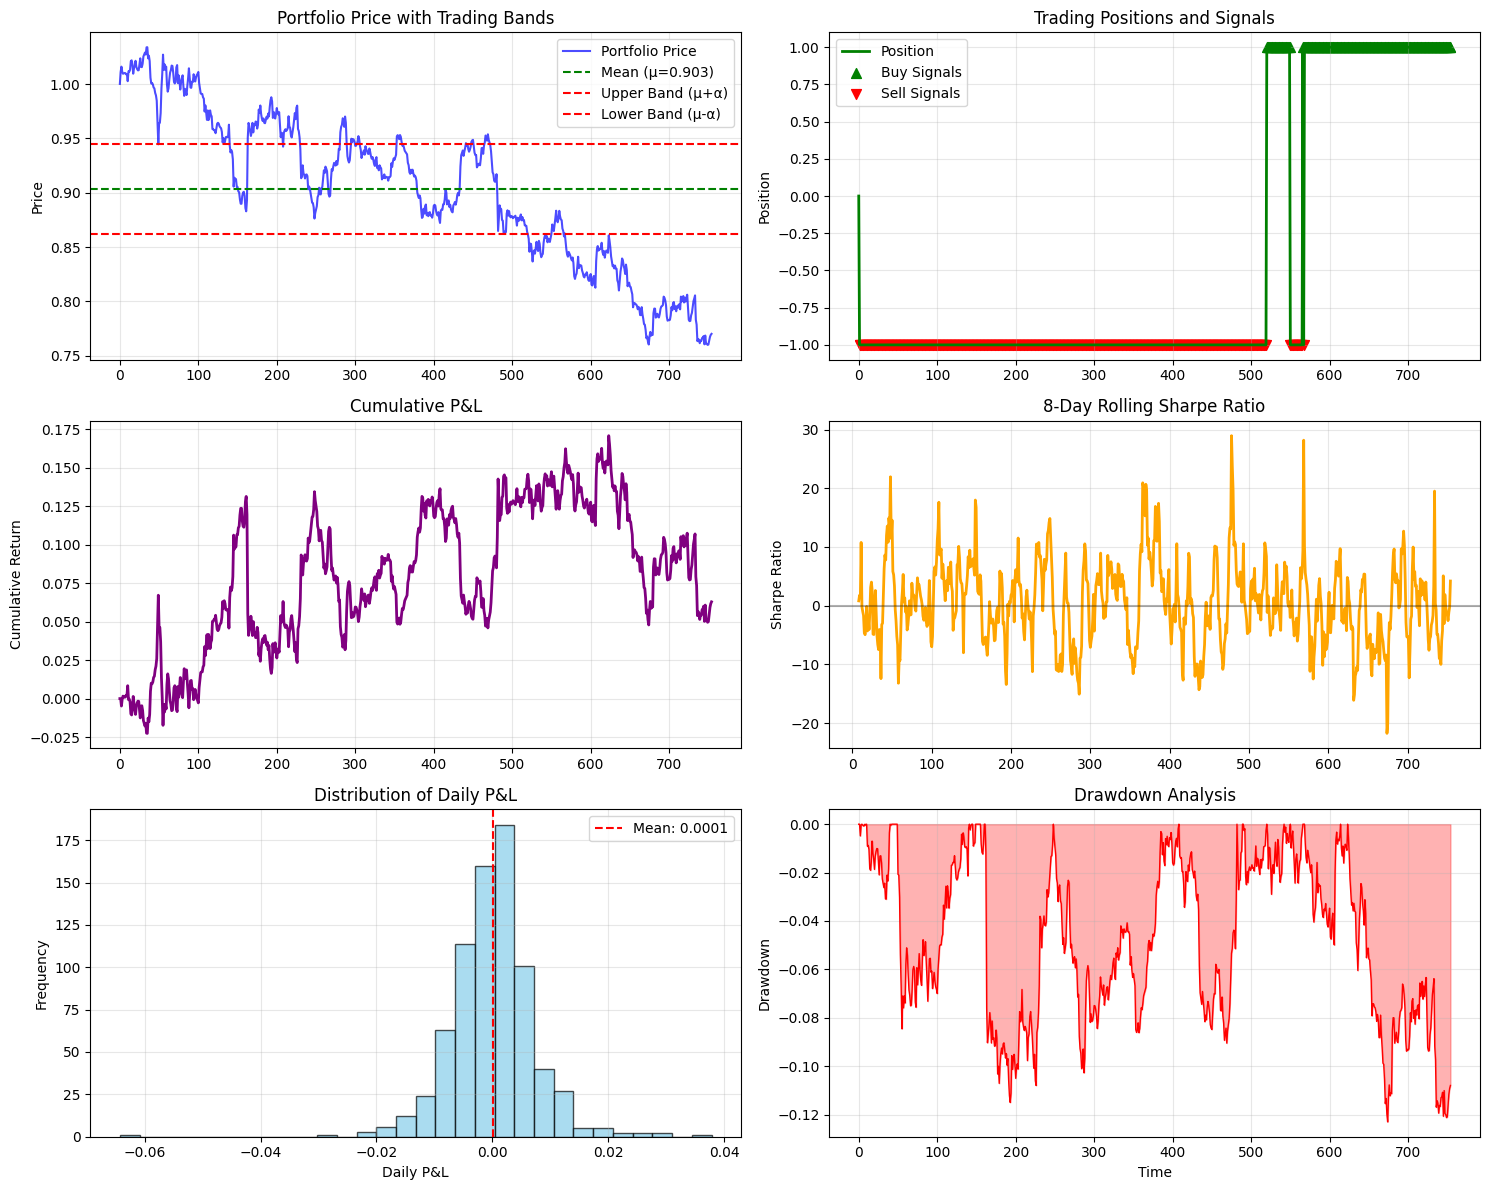


🚀 IMPLEMENTING TRADING STRATEGY: Greedy Selection
📊 Selected Assets: ['AMZN', 'AVGO', 'CRM', 'META', 'NVDA']
📊 Portfolio Weights: ['0.8553', '-0.1712', '-0.3686', '-0.1477', '-0.2855']

🔍 PARAMETER ESTIMATION:
📊 Ornstein-Uhlenbeck Parameter Estimation:
   Long-term mean (μ): 0.8115
   Mean reversion speed (λ): 0.1000
   Volatility (σ): 0.0215
   Half-life: 6.9 periods

🔍 Comparison with Least Squares:
📊 Least Squares Parameter Estimation:
   Long-term mean (μ): 0.6718
   Mean reversion speed (λ): 0.0041
   Volatility (σ): 0.0152
   R²: 0.9908

⚙️ THRESHOLD OPTIMIZATION:
📊 Trading Threshold Optimization:
   Stationary std: 0.0480
   Optimal threshold (α): 0.0942
   Trading bands: [0.7173, 0.9056]

📈 TRADING SIMULATION:
📊 Trading Strategy Performance:
   Total Return: 25.4%
   Volatility: 27.5%
   Sharpe Ratio: 0.31
   Max Drawdown: -30.2%
   Number of Trades: 10
   Hit Rate: 51.8%

📊 GENERATING ANALYSIS PLOTS...


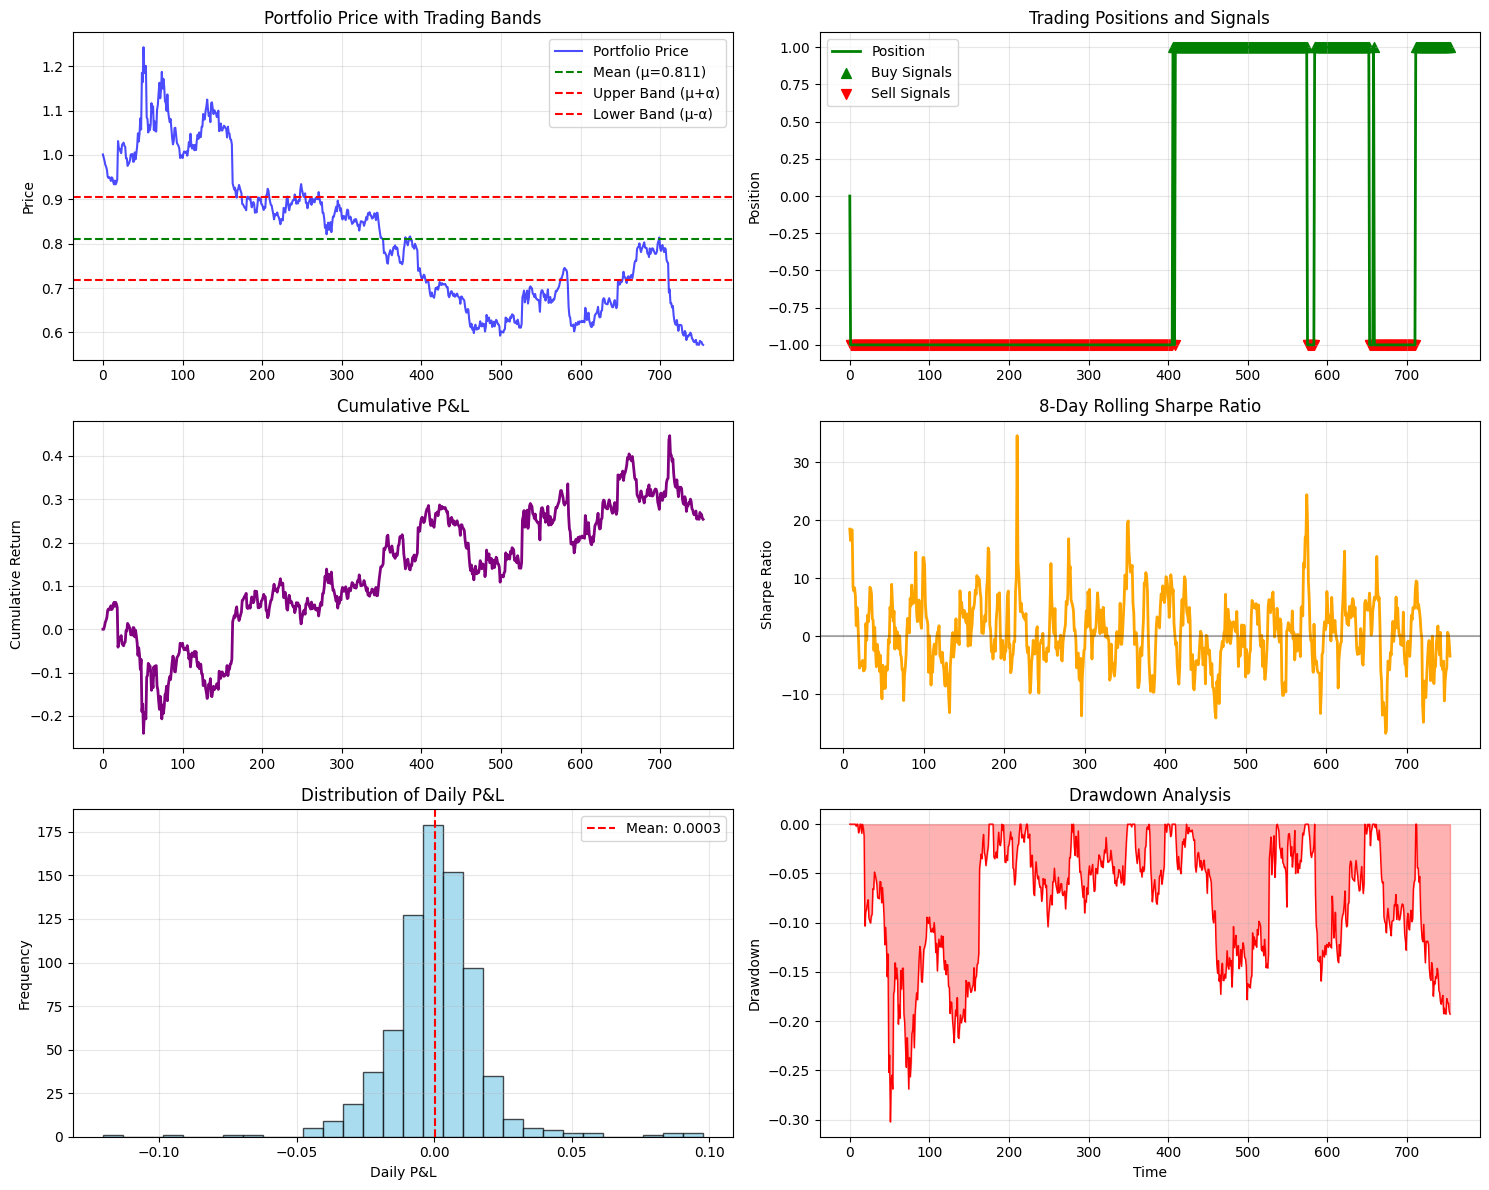


🚀 IMPLEMENTING TRADING STRATEGY: Truncation
📊 Selected Assets: ['AAPL', 'AMZN', 'AVGO', 'GOOGL', 'MSFT']
📊 Portfolio Weights: ['0.2733', '0.3775', '-0.4128', '0.2164', '-0.7521']

🔍 PARAMETER ESTIMATION:
📊 Ornstein-Uhlenbeck Parameter Estimation:
   Long-term mean (μ): 0.8377
   Mean reversion speed (λ): 0.1000
   Volatility (σ): 0.0176
   Half-life: 6.9 periods

🔍 Comparison with Least Squares:
📊 Least Squares Parameter Estimation:
   Long-term mean (μ): 0.6604
   Mean reversion speed (λ): 0.0033
   Volatility (σ): 0.0126
   R²: 0.9903

⚙️ THRESHOLD OPTIMIZATION:
📊 Trading Threshold Optimization:
   Stationary std: 0.0394
   Optimal threshold (α): 0.0772
   Trading bands: [0.7605, 0.9149]

📈 TRADING SIMULATION:
📊 Trading Strategy Performance:
   Total Return: 8.7%
   Volatility: 21.4%
   Sharpe Ratio: 0.14
   Max Drawdown: -27.7%
   Number of Trades: 10
   Hit Rate: 51.5%

📊 GENERATING ANALYSIS PLOTS...


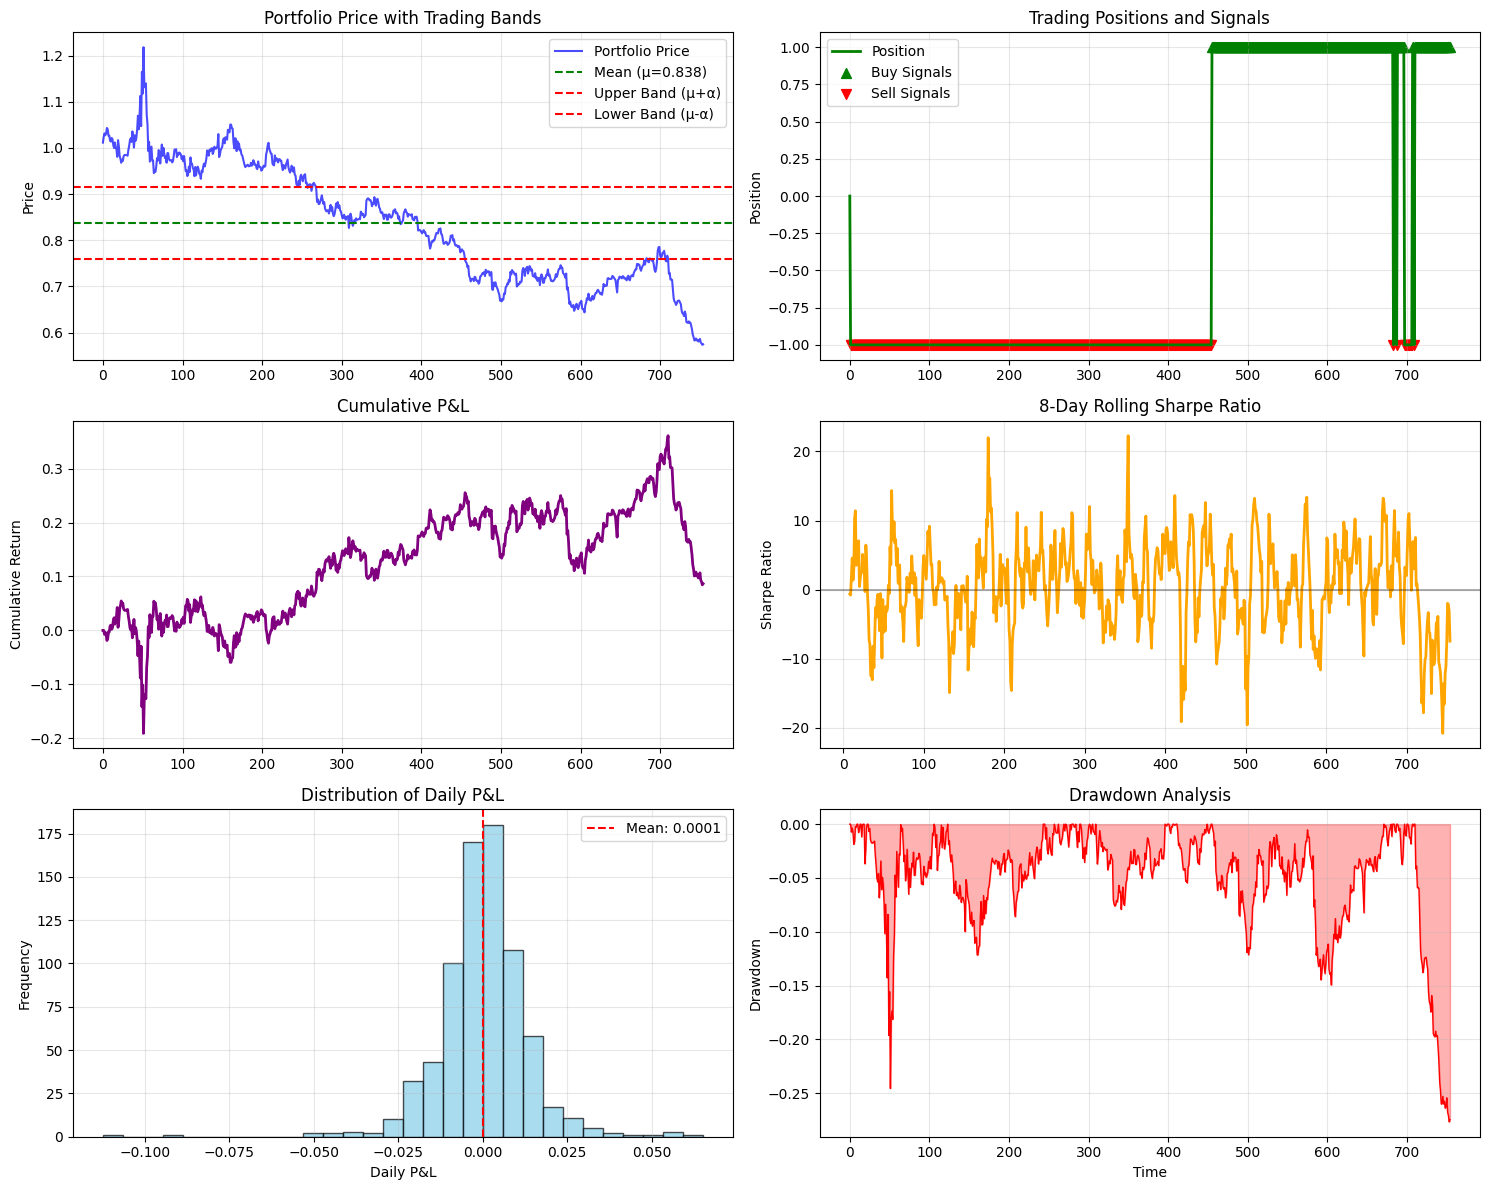


🏆 TRADING PERFORMANCE COMPARISON
📊 COMPREHENSIVE PERFORMANCE METRICS:
--------------------------------------------------------------------------------
             Method  Predictability_λ  Trading_Return  Trading_Sharpe  Max_Drawdown  Num_Trades  Hit_Rate
Simulated Annealing            0.1232          0.0629          0.1806       -0.1230           6    0.5193
   Greedy Selection            0.1779          0.2537          0.3079       -0.3024          10    0.5179
         Truncation            0.1451          0.0865          0.1353       -0.2768          10    0.5153

🏆 BEST METHODS BY CRITERIA:
----------------------------------------
📈 Best Predictability: Greedy Selection (λ=0.1779)
💰 Best Trading Return: Greedy Selection (25.4%)
⚡ Best Sharpe Ratio: Greedy Selection (0.31)
🛡️ Best Risk Control: Simulated Annealing (-12.3% max DD)

📊 RISK-RETURN ANALYSIS:
----------------------------------------


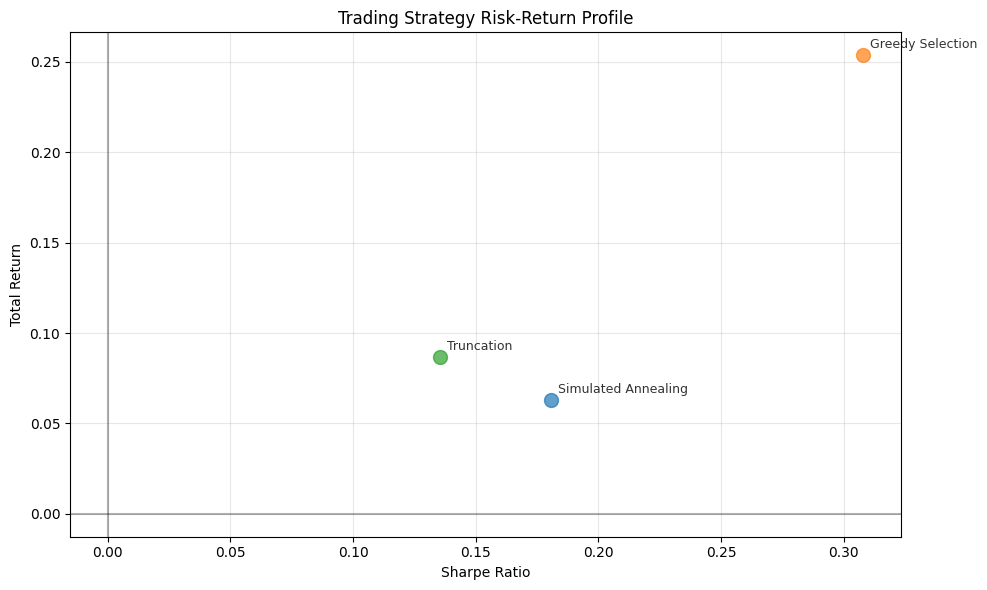


✅ COMPLETE PIPELINE ANALYSIS FINISHED!
📊 Successfully implemented and tested 3 optimization methods
🚀 From portfolio selection to live trading simulation - all based on the paper's methodology!


In [75]:
# ============================================================================
# STEP 4: Complete Pipeline - Portfolio Optimization + Trading Implementation  
# ============================================================================

def complete_trading_pipeline(method_results, returns_matrix, asset_names):
    """
    Complete pipeline from portfolio optimization to trading implementation
    """
    
    trading_results = {}
    
    for method_name, result in method_results.items():
        if result is not None:
            print(f"\n{'='*60}")
            print(f"🚀 IMPLEMENTING TRADING STRATEGY: {result['method']}")
            print(f"{'='*60}")
            
            # Get optimal portfolio weights
            portfolio_weights = result['portfolio'].weights
            
            # Initialize the trader
            trader = MeanReversionTrader(
                portfolio_weights=portfolio_weights,
                returns_data=returns_matrix,
                asset_names=asset_names
            )
            
            print(f"📊 Selected Assets: {result['selected_assets']}")
            print(f"📊 Portfolio Weights: {[f'{w:.4f}' for w in portfolio_weights[portfolio_weights != 0]]}")
            
            try:
                # Step 1: Estimate OU parameters using both methods
                print(f"\n🔍 PARAMETER ESTIMATION:")
                
                # Method 1: Pattern matching (from the paper)
                mu_pm, lambda_pm, sigma_pm = trader.estimate_ou_parameters('pattern_matching')
                
                # Method 2: Least squares (for comparison)
                print(f"\n🔍 Comparison with Least Squares:")
                mu_ls, lambda_ls, sigma_ls = trader.estimate_ou_parameters('least_squares')
                
                # Use pattern matching results (paper's method)
                trader.mu, trader.lambda_param, trader.sigma = mu_pm, lambda_pm, sigma_pm
                
                # Step 2: Optimize trading threshold
                print(f"\n⚙️ THRESHOLD OPTIMIZATION:")
                alpha = trader.optimize_trading_threshold()
                
                # Step 3: Simulate trading strategy
                print(f"\n📈 TRADING SIMULATION:")
                strategy_results = trader.simulate_trading_strategy()
                
                # Store results
                trading_results[method_name] = {
                    'trader': trader,
                    'strategy_results': strategy_results,
                    'parameters': {
                        'mu': mu_pm,
                        'lambda': lambda_pm, 
                        'sigma': sigma_pm,
                        'alpha': alpha
                    },
                    'portfolio_info': {
                        'method': result['method'],
                        'predictability': result['score'],
                        'selected_assets': result['selected_assets'],
                        'weights': portfolio_weights[portfolio_weights != 0]
                    }
                }
                
                # Step 4: Generate plots
                print(f"\n📊 GENERATING ANALYSIS PLOTS...")
                trader.plot_trading_analysis(strategy_results)
                
            except Exception as e:
                print(f"❌ Error in trading implementation for {result['method']}: {e}")
                continue
    
    return trading_results

# Run the complete pipeline
print("🚀 RUNNING COMPLETE TRADING PIPELINE")
print("="*80)

# Assume all_results is available from previous cell
# We'll test with the best performing methods
if 'all_results' in locals():
    
    # Select methods to test (skip exhaustive if it takes too long)
    methods_to_test = {}
    for method_name in ['SimAnnealing', 'Greedy', 'Truncation']:
        if method_name in all_results and all_results[method_name] is not None:
            methods_to_test[method_name] = all_results[method_name]
    
    if len(methods_to_test) > 0:
        # Run complete pipeline
        trading_results = complete_trading_pipeline(
            method_results=methods_to_test,
            returns_matrix=returns_matrix,
            asset_names=asset_names
        )
        
        # Compare trading performance across methods
        print(f"\n{'='*80}")
        print("🏆 TRADING PERFORMANCE COMPARISON")
        print(f"{'='*80}")
        
        performance_summary = []
        
        for method_name, results in trading_results.items():
            strategy_perf = results['strategy_results']
            portfolio_info = results['portfolio_info']
            
            performance_summary.append({
                'Method': portfolio_info['method'],
                'Predictability_λ': portfolio_info['predictability'],
                'Trading_Return': strategy_perf['total_return'],
                'Trading_Sharpe': strategy_perf['sharpe_ratio'],
                'Max_Drawdown': strategy_perf['max_drawdown'],
                'Num_Trades': strategy_perf['num_trades'],
                'Hit_Rate': strategy_perf['hit_rate']
            })
        
        # Create comparison DataFrame
        performance_df = pd.DataFrame(performance_summary)
        
        print("📊 COMPREHENSIVE PERFORMANCE METRICS:")
        print("-" * 80)
        print(performance_df.to_string(index=False, float_format='%.4f'))
        
        # Find best method by different criteria
        print(f"\n🏆 BEST METHODS BY CRITERIA:")
        print("-" * 40)
        
        if len(performance_df) > 0:
            best_predictability = performance_df.loc[performance_df['Predictability_λ'].idxmax()]
            best_return = performance_df.loc[performance_df['Trading_Return'].idxmax()]
            best_sharpe = performance_df.loc[performance_df['Trading_Sharpe'].idxmax()]
            best_drawdown = performance_df.loc[performance_df['Max_Drawdown'].idxmax()]  # Least negative
            
            print(f"📈 Best Predictability: {best_predictability['Method']} (λ={best_predictability['Predictability_λ']:.4f})")
            print(f"💰 Best Trading Return: {best_return['Method']} ({best_return['Trading_Return']:.1%})")
            print(f"⚡ Best Sharpe Ratio: {best_sharpe['Method']} ({best_sharpe['Trading_Sharpe']:.2f})")
            print(f"🛡️ Best Risk Control: {best_drawdown['Method']} ({best_drawdown['Max_Drawdown']:.1%} max DD)")
        
        # Risk-Return Analysis
        print(f"\n📊 RISK-RETURN ANALYSIS:")
        print("-" * 40)
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        for i, row in performance_df.iterrows():
            ax.scatter(row['Trading_Sharpe'], row['Trading_Return'], 
                      s=100, alpha=0.7, label=row['Method'])
            
            # Add method labels
            ax.annotate(row['Method'], 
                       (row['Trading_Sharpe'], row['Trading_Return']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, alpha=0.8)
        
        ax.set_xlabel('Sharpe Ratio')
        ax.set_ylabel('Total Return')
        ax.set_title('Trading Strategy Risk-Return Profile')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ COMPLETE PIPELINE ANALYSIS FINISHED!")
        print(f"📊 Successfully implemented and tested {len(trading_results)} optimization methods")
        print(f"🚀 From portfolio selection to live trading simulation - all based on the paper's methodology!")
        
    else:
        print("❌ No optimization results available. Please run the optimization comparison first.")
        
else:
    print("❌ Variable 'all_results' not found. Please run the optimization comparison first.")
    print("💡 Make sure to run the previous cells that generate optimization results.")
